In [49]:
from typing import Literal
from langchain_core.tools import tool
from matplotlib import figure
from langchain_ibm import ChatWatsonx

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
import utils
from dotenv import load_dotenv
import os

In [50]:
class TempGraphInputSchema(BaseModel):
    """Start and end dates for temperature graph generation."""
    start_date: str = Field(description="Start date in the format YYYY.MM")
    end_date: str = Field(description="End date in the format YYYY.MM")

@tool("create_temperature_graph", args_schema=TempGraphInputSchema)
def create_temperature_graph(start_date: str, end_date: str) -> figure:
    return utils.plot_temps(start_date, end_date)

class Co2GraphInputSchema(BaseModel):
    """Start and end dates for temperature graph generation."""
    start_date: str = Field(description="Start date in the format YYYY.MM.DD")
    end_date: str = Field(description="End date in the format YYYY.MM.DD")

@tool("create_co2_graph", args_schema=Co2GraphInputSchema)
def create_co2_graph(start_date: str, end_date: str) -> figure:
    return utils.plot_co2(start_date, end_date)

In [51]:
load_dotenv()

parameters = {"max_new_tokens": 1024, "decoding_method": "sample", "temperature": 0.2}
ibm_chat = ChatWatsonx(
    url=os.getenv("URL"),
    apikey=os.getenv("API_KEY"),
    project_id=os.getenv("PROJECT_ID"),
    model_id="meta-llama/llama-3-3-70b-instruct",
    params=parameters,
)

In [52]:

def router(
    state: list[BaseMessage],
) -> Literal["create_temperature_graph","create_co2_graph", "__end__"]:
    """Creates tempreture graph."""
    # Get the tool_calls from the last message in the conversation history.
    tool_calls = state[-1].tool_calls

    # If there are any tool_calls
    if tool_calls:
        # Check the function name in the first tool call
        function_name = tool_calls[0].get("name")
        if function_name == "create_temperature_graph":
            return "create_temperature_graph"
        else:
            return "create_co2_graph"
    else:
        # End the conversation flow.
        return "__end__"

In [53]:
class LangGraphApp:
    # The set_up method is used to define application initialization logic
    def set_up(self) -> None:
        model = ibm_chat
        builder = MessageGraph()

        model_with_tools = model.bind_tools([create_temperature_graph, create_co2_graph])
        builder.add_node("tools", model_with_tools)

        tool_node = ToolNode([create_temperature_graph, create_co2_graph])
        builder.add_node("create_temperature_graph", tool_node)
        builder.add_node("create_co2_graph", tool_node)
        builder.add_edge("create_temperature_graph", END)
        builder.add_edge("create_co2_graph", END)

        builder.set_entry_point("tools")
        builder.add_conditional_edges("tools", router)
        self.app = builder.compile()

    # The query method will be used to send inputs to the agent
    def query(self, input: str):
        """Query the application."""
        chat_history = (self.app.invoke(HumanMessage(input)))
        return chat_history

In [54]:

local_custom_agent = LangGraphApp()
local_custom_agent.set_up()

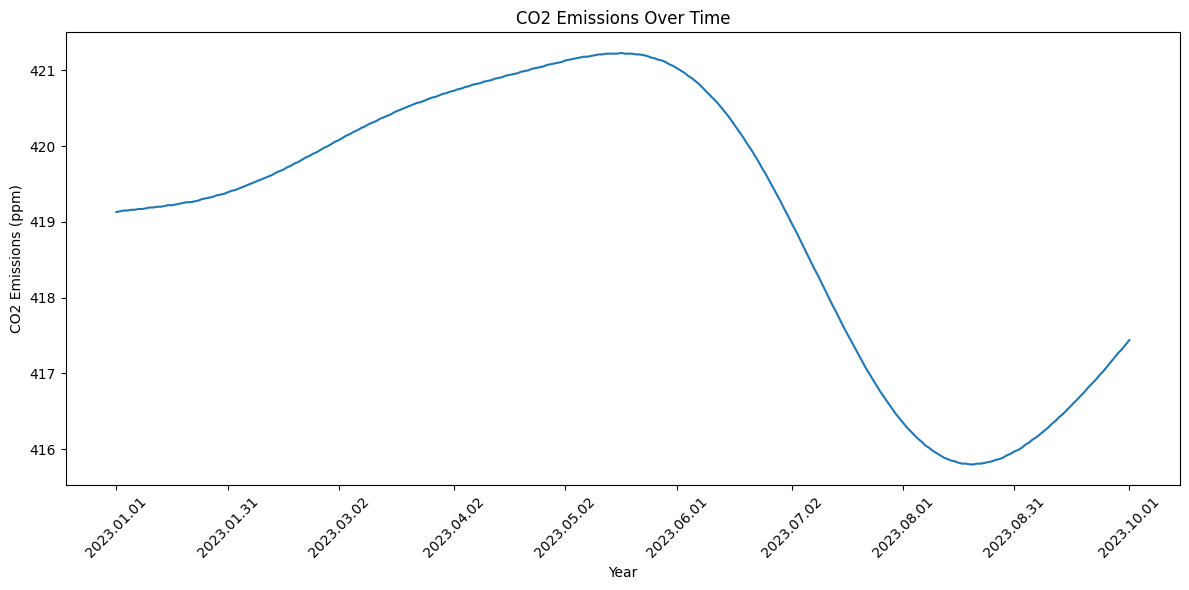

In [55]:
response = local_custom_agent.query(input="how much more co2 in between 2023.01.01 and 2023.10.01")


In [56]:
response

[HumanMessage(content='how much more co2 in between 2023.01.01 and 2023.10.01', additional_kwargs={}, response_metadata={}, id='6d67fdd5-2c04-4038-a929-baaf28b96fdb'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-639d8d1094984cce8e23c291b6bd35d3', 'type': 'function', 'function': {'name': 'create_co2_graph', 'arguments': '{"start_date": "2023.01.01", "end_date": "2023.10.01"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 446, 'total_tokens': 489}, 'model_name': 'meta-llama/llama-3-3-70b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-9cada10dcd44ef8f9fb60afc9911c9ae', tool_calls=[{'name': 'create_co2_graph', 'args': {'start_date': '2023.01.01', 'end_date': '2023.10.01'}, 'id': 'chatcmpl-tool-639d8d1094984cce8e23c291b6bd35d3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 446, 'output_tokens': 43, 'total_tokens': 489}),
 ToolMessage(content="(<Figure size 1200x600 with 1 Axes